<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/FeatureSelection/EmbeddedMethods/3_5_Regression_coefficients_and_regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression Coefficients are affected by regularisation

As I mentioned previously, regularisation applies a penalty on the coefficients, in order to reduce their influence and create models that generalise better. This is very good to improve  model performance. However, it masks the true relationship between the predictor X and the outcome Y. Let's explore why.

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [4]:
!pip install --user kaggle
!mkdir .kaggle
import json
token = {"username":"#####","key":"######"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

mkdir: cannot create directory ‘.kaggle’: File exists


In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c bnp-paribas-cardif-claims-management
!unzip train.csv.zip

 57% 28.0M/49.4M [00:00<00:00, 59.5MB/s]
100% 49.4M/49.4M [00:00<00:00, 165MB/s] 
 83% 41.0M/49.4M [00:00<00:00, 35.6MB/s]
100% 49.4M/49.4M [00:00<00:00, 91.6MB/s]
  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 145MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [6]:
# load dataset
data = pd.read_csv('train.csv', nrows=50000)
data.shape

(50000, 133)

In [7]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,...,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,...,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,...,0.763925,5.498902,3.423944,0.832518,7.375480,6.746988,6.942002,1.334611,18.256352,8.507281,2.503055,4.872157,2.573664,0.113967,12.554274,B,2.230754,1.990131,B,2.643678,J,NaN,13.777666,10.574713,1.511063,4.949609,7.180722,5.655086e-01,1.166281,1.956521,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,NaN,6.320087,NaN,10.991098,NaN,NaN,NaN,NaN,NaN,NaN,6.414567,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,6.083151,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,A,NaN,T,G,14.097099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [8]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

In [9]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

Let's fit a few logistic regression models decreasing the penalty of the regularisation.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

# I build 4 different models, from a highly regularised one
# to a non regularised one (C=1000)
coefs_df = []
for c in [1, 10, 100, 1000]:
    logit = LogisticRegression(C=c, penalty='l2')
    logit.fit(scaler.transform(X_train.fillna(0)), y_train)
    
    # store the coefficients of the variables in a list
    coefs_df.append(pd.Series(logit.coef_.ravel()))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [11]:
# now I create a dataframe with the coefficients for all
# the variables for the 4 different logistic regression models

coefs = pd.concat(coefs_df, axis=1)
coefs.columns = [1, 10, 100, 1000]
coefs.index = X_train.columns
coefs.head()

,1,10,100,1000
v1,-0.065969,-0.072396,-0.070862,-0.074031
v2,0.119062,0.131676,0.124779,0.123567
v4,0.001461,0.008195,0.015091,0.008380
v5,0.128045,0.149829,0.138334,0.134068
v6,0.187444,0.173511,0.195971,0.192673


In [12]:
coefs.columns = np.log([1, 10, 100, 1000])
coefs.head()

,0.000000,2.302585,4.605170,6.907755
v1,-0.065969,-0.072396,-0.070862,-0.074031
v2,0.119062,0.131676,0.124779,0.123567
v4,0.001461,0.008195,0.015091,0.008380
v5,0.128045,0.149829,0.138334,0.134068
v6,0.187444,0.173511,0.195971,0.192673


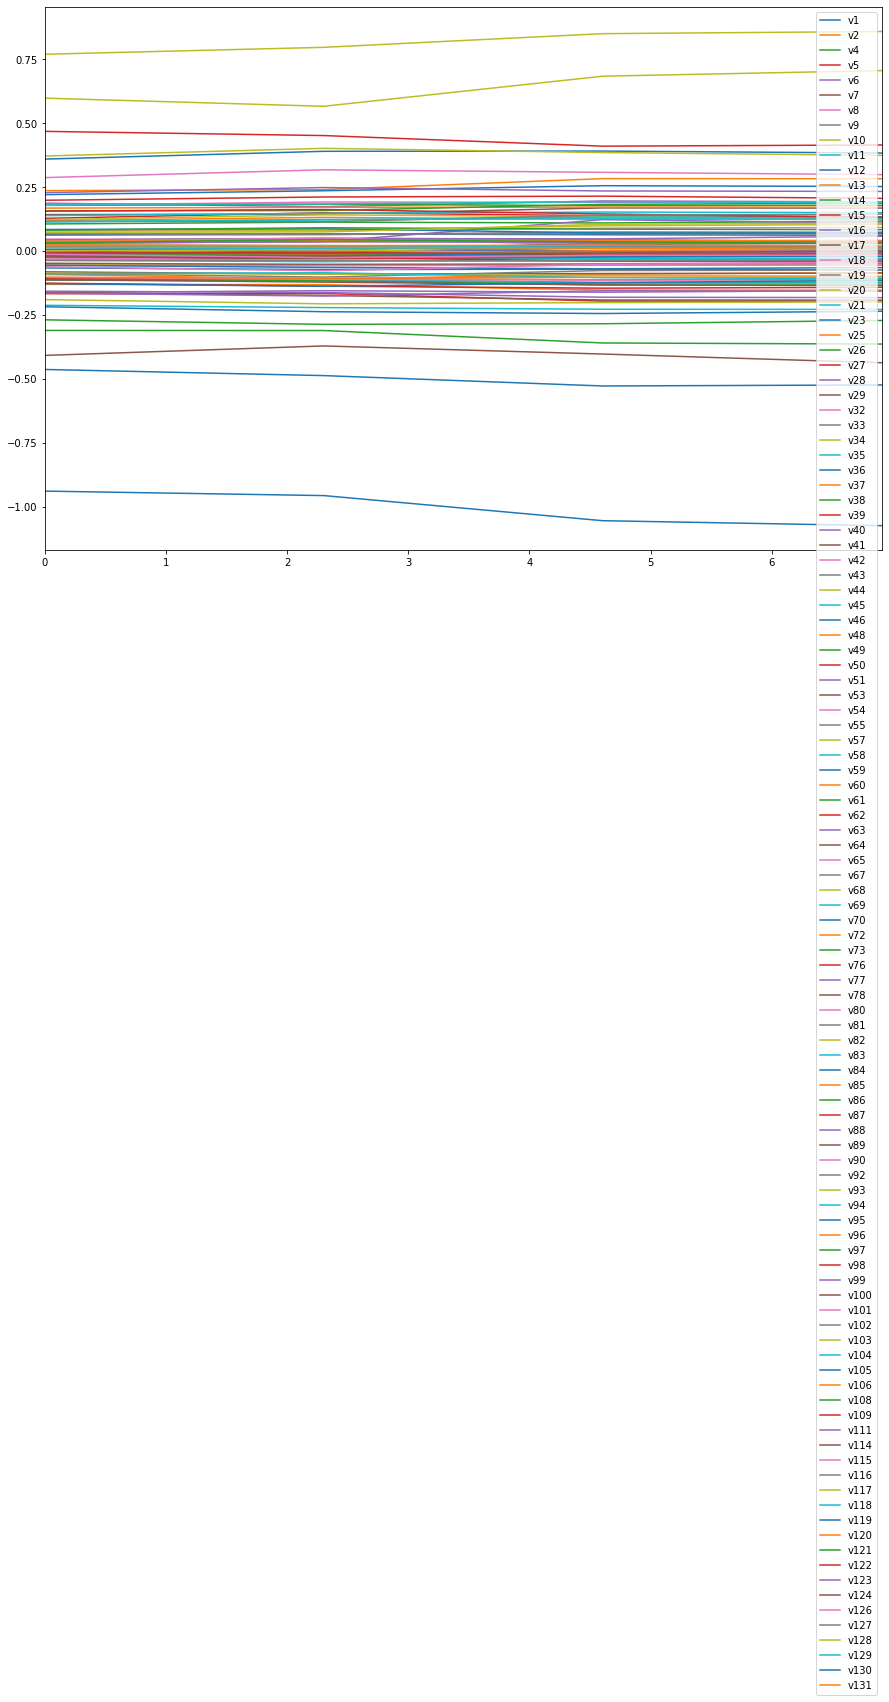

In [13]:
# plot the change in coefficients with the penalty
coefs.T.plot(figsize=(15,10))

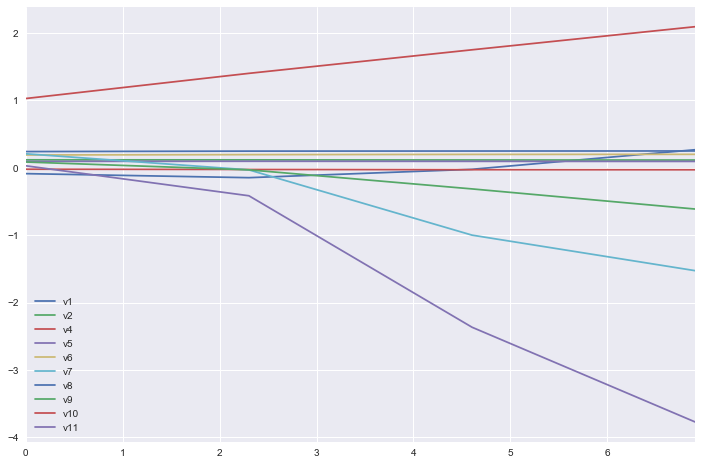

In [0]:
# now I will plot only the first 10 features for better
# visualisation

temp = coefs.head(10)
temp = temp.T
temp.plot(figsize=(12,8))

We can see that the relation among the coefficients is complex. Some features show bigger coefficients than others without regularisation, but when the penalty increases this relationship changes.

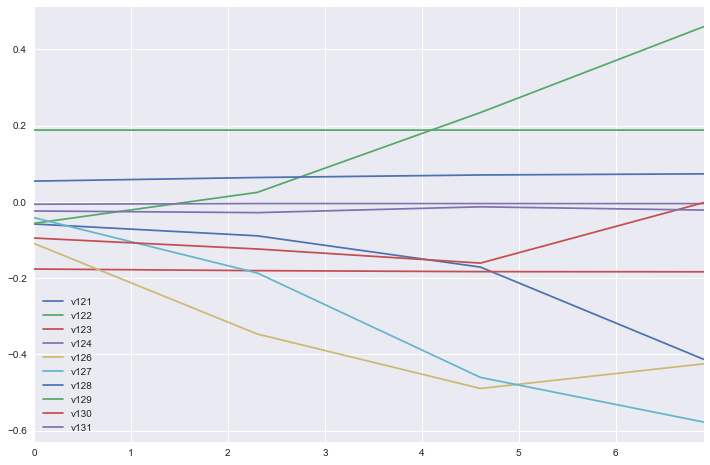

In [0]:
# plot another 10 features for visualisation
temp = coefs.tail(10)
temp = temp.T
temp.plot(figsize=(12,8))

Same as before, the relationship between features, as inferred from the coefficients, changes depending on the level of regularisation.

That is all for this demonstration, see you in the next one.